**Methods to Salvage the Study**

In the context of a randomized controlled trial (RTC), encountering a failure to produce a control group can pose significant challenges. However, there are innovative methods to salvage such studies by leveraging auxiliary data, such as temperature trends, to extrapolate a potential energy usage profile for the control group.

Prophet, a forecasting tool developed by Facebook, plays a pivotal role in this approach. Prophet utilizes time series data and incorporates various components, including seasonal patterns, holiday effects, and user-defined regressors like temperature, to model and forecast future trends in energy consumption. By integrating temperature as a regressor, Prophet can capture how variations in temperature influence energy usage patterns. This capability is particularly useful when direct control group data is unavailable or insufficient.

In practical terms, if traditional control group data collection fails, Prophet can step in to estimate how energy usage might unfold under normal conditions based on observed temperature trends. This methodological adaptation not only preserves the integrity of the study by maintaining a comparative framework but also enhances its robustness by providing insights into potential outcomes that align with real-world conditions. This innovative use of Prophet ensures that despite initial setbacks in data collection, meaningful insights can still be derived, thus safeguarding the overall validity and relevance of the study's findings.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import os
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
from scipy.stats import norm  # Import norm from scipy.stats

In [ ]:
!pip install linearmodels
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

!pip install prophet
from prophet import Prophet

                          PanelOLS Estimation Summary                           
Dep. Variable:           energy_usage   R-squared:                        0.7018
Estimator:                   PanelOLS   R-squared (Between):              0.3381
No. Observations:                2400   R-squared (Within):               0.8332
Date:                Mon, Jul 22 2024   R-squared (Overall):              0.7018
Time:                        04:44:38   Log-likelihood                   -6434.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      117.79
Entities:                         100   P-value                           0.0000
Avg Obs:                       24.000   Distribution:                 F(47,2352)
Min Obs:                       24.000                                           
Max Obs:                       24.000   F-statistic (robust):             117.79
                            

Text(0.5, 0, 'Observations')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot')

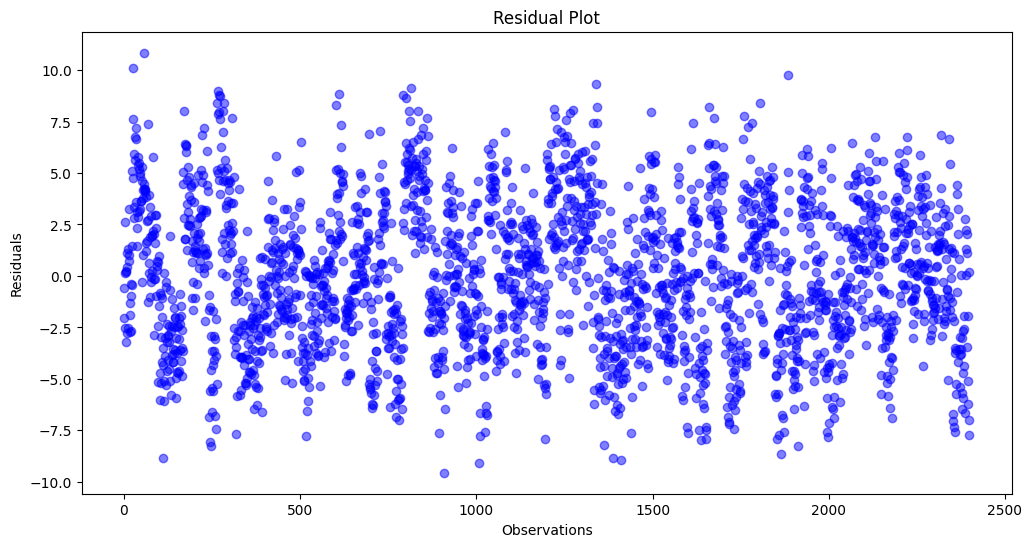


R-squared: 0.7018340643866059


In [5]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_households = 100
n_hours = 24
treatment_households = 50

# Create base DataFrame with correct household IDs
households = np.repeat(np.arange(n_households), n_hours)
df = pd.DataFrame({
    'household_id': households,
    'hour': np.tile(np.arange(n_hours), n_households),
    'treatment': np.repeat(np.concatenate([np.ones(treatment_households), np.zeros(n_households - treatment_households)]), n_hours)
})

# Function to generate energy usage
def generate_energy_usage(hour, is_treatment, base_load, peak_load, peak_hours, pre_cooling_hours):
    if is_treatment:
        if hour in peak_hours:
            return base_load * 0.8  # Reduced load during peak hours for treatment group
        elif hour in pre_cooling_hours:
            return base_load * 1.2  # Increased load during pre-cooling for treatment group
        else:
            return base_load
    else:
        if hour in peak_hours:
            return peak_load  # Higher load during peak hours for control group
        else:
            return base_load

# Generate energy usage
base_loads = np.random.uniform(25, 35, n_households)  # Random base load kW per household
peak_loads = np.random.uniform(40, 50, n_households)  # Random peak load kW per household
peak_hours = range(11, 16)  # 11 AM to 3 PM
pre_cooling_hours = range(7, 11)  # 7 AM to 10 AM

# Vectorized operation to generate energy usage for each household
df['energy_usage'] = [
    generate_energy_usage(hour, treatment, base_loads[household], peak_loads[household], peak_hours, pre_cooling_hours)
    for hour, treatment, household in zip(df['hour'], df['treatment'], df['household_id'])
]

# Add some random noise
df['energy_usage'] += np.random.normal(0, 2, len(df))

# Ensure non-negative energy usage
df['energy_usage'] = df['energy_usage'].clip(lower=0)

# Add temperature data (assuming it's the same for all households)
temp_base = 70  # Base temperature
temp_peak = 95  # Peak temperature
temp_curve = norm.pdf(np.arange(n_hours), loc=12, scale=4)  # Normal distribution centered at noon
temp_curve = (temp_curve - temp_curve.min()) / (temp_curve.max() - temp_curve.min())
temperatures = temp_base + temp_curve * (temp_peak - temp_base)
df['temperature'] = df['hour'].map(dict(enumerate(temperatures)))

# Convert hour to categorical
df['hour2'] = pd.Categorical(df['hour'])

# Assuming x1 is a variable of interest (randomly generated for demonstration)
df['x1'] = np.random.normal(0, 1, size=len(df))

# Create a panel DataFrame
df_s = df.set_index(['household_id', 'hour'])

# Specify the regression model
mod = PanelOLS.from_formula('energy_usage ~ 1 + hour2*treatment', drop_absorbed=True, check_rank=False, data=df_s)

# Fit the model
res = mod.fit()

# Print regression results
print(res)

# Additional diagnostics
print(res.summary)

# Plot residuals
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(res.resids.values, marker='o', linestyle='None', color='b', alpha=0.5)
ax.set_xlabel('Observations')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

# Access specific statistics from the results
print("\nR-squared:", res.rsquared)

In [6]:
import pandas as pd

# Example: Aggregate data for control group (hourly averages)
control_energy = df[df['treatment'] == 0].groupby('hour')['energy_usage'].mean().reset_index()
control_temperature = df[df['treatment'] == 0].groupby('hour')['temperature'].mean().reset_index()

# Merge the aggregated data
control_data = pd.merge(control_energy, control_temperature, on='hour', suffixes=('_energy', '_temperature'))

# Construct a full datetime column (assuming a fixed date)
control_data['ds'] = pd.to_datetime('2024-07-19 ' + control_data['hour'].astype(str) + ':00:00')

# Drop the 'hour' column if it's no longer needed
control_data.drop(columns='hour', inplace=True)

# Rename columns as needed
control_data.rename(columns={'energy_usage': 'y', 'temperature': 'temperature'}, inplace=True)

# Display the DataFrame information to check the dtype of 'ds'
print(control_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   y            24 non-null     float64       
 1   temperature  24 non-null     float64       
 2   ds           24 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2)
memory usage: 704.0 bytes
None


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb_zoiao/shu5t_0t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb_zoiao/0bx8wca9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97693', 'data', 'file=/tmp/tmpdb_zoiao/shu5t_0t.json', 'init=/tmp/tmpdb_zoiao/0bx8wca9.json', 'output', 'file=/tmp/tmpdb_zoiao/prophet_modelrp63vp1t/prophet_model-20240722044455.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:44:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:44:55 - cmdstanpy - INFO - Chain [1] done processing
INF

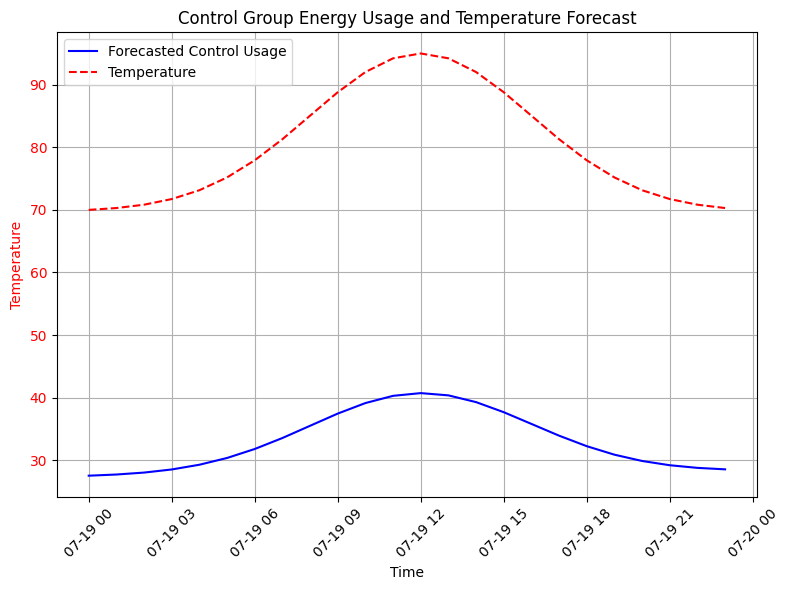

In [7]:
# Initialize Prophet model with regressor
control_model = Prophet(daily_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=5)
control_model.add_regressor('temperature')

# Fit the model on control data
control_model.fit(control_data)

# Create future dataframe for forecasting
start_date = '2024-07-19 00:00'
end_date = '2024-07-19 23:00'
future_control = pd.DataFrame({'ds': pd.date_range(start=start_date, end=end_date, freq='H')})
future_control['temperature'] = temperatures[:len(future_control)]

# Forecasting
forecast_control = control_model.predict(future_control)

#Plotting
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot forecasted data on the primary y-axis (left)
ax1.plot(forecast_control['ds'], forecast_control['yhat'], label='Forecasted Control Usage', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Usage (kW)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Plot temperature on the same primary y-axis (left) for comparison
ax1.plot(control_data['ds'], control_data['temperature'], label='Temperature', linestyle='--', color='red')
ax1.set_ylabel('Temperature', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Control Group Energy Usage and Temperature Forecast')
ax1.legend(loc='upper left')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

In [8]:
forecast_control.info()
future_control.info()
control_data.info()

forecast_control.head(5)
forecast_control.tail(5)

future_control.tail()
control_data.tail()

merged_data = pd.merge(forecast_control, control_data[['ds', 'y']], on='ds')

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               24 non-null     datetime64[ns]
 1   trend                            24 non-null     float64       
 2   yhat_lower                       24 non-null     float64       
 3   yhat_upper                       24 non-null     float64       
 4   trend_lower                      24 non-null     float64       
 5   trend_upper                      24 non-null     float64       
 6   additive_terms                   24 non-null     float64       
 7   additive_terms_lower             24 non-null     float64       
 8   additive_terms_upper             24 non-null     float64       
 9   extra_regressors_additive        24 non-null     float64       
 10  extra_regressors_additive_lower  24 non-null     float64       


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,temperature,temperature_lower,temperature_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-19 00:00:00,32.750743,22.010715,32.708486,32.750743,32.750743,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,0.0,0.0,0.0,27.524362
1,2024-07-19 01:00:00,32.788086,22.536022,32.964438,32.788086,32.788086,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,0.0,0.0,0.0,27.712321
2,2024-07-19 02:00:00,32.825428,22.736946,33.613654,32.825428,32.825428,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,0.0,0.0,0.0,28.022182
3,2024-07-19 03:00:00,32.862771,23.064296,34.118731,32.862771,32.862771,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,0.0,0.0,0.0,28.518681
4,2024-07-19 04:00:00,32.900114,24.024942,34.970548,32.900114,32.900114,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,0.0,0.0,0.0,29.274943


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,temperature,temperature_lower,temperature_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
19,2024-07-19 19:00:00,33.464335,25.580414,36.225314,33.464335,33.464335,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,0.0,0.0,0.0,30.882308
20,2024-07-19 20:00:00,33.502005,24.430453,35.506185,33.502005,33.502005,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,0.0,0.0,0.0,29.876835
21,2024-07-19 21:00:00,33.539675,24.495411,34.339230,33.539675,33.539675,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,0.0,0.0,0.0,29.195585
22,2024-07-19 22:00:00,33.577344,23.232526,34.184139,33.577344,33.577344,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,0.0,0.0,0.0,28.774098
23,2024-07-19 23:00:00,33.615014,23.313932,34.022398,33.615014,33.615014,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,0.0,0.0,0.0,28.539249


,ds,temperature
19,2024-07-19 19:00:00,75.186521
20,2024-07-19 20:00:00,73.140545
21,2024-07-19 21:00:00,71.730487
22,2024-07-19 22:00:00,70.829918
23,2024-07-19 23:00:00,70.295411


,y,temperature,ds
19,30.033753,75.186521,2024-07-19 19:00:00
20,30.065544,73.140545,2024-07-19 20:00:00
21,30.068757,71.730487,2024-07-19 21:00:00
22,29.880271,70.829918,2024-07-19 22:00:00
23,30.039109,70.295411,2024-07-19 23:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               24 non-null     datetime64[ns]
 1   trend                            24 non-null     float64       
 2   yhat_lower                       24 non-null     float64       
 3   yhat_upper                       24 non-null     float64       
 4   trend_lower                      24 non-null     float64       
 5   trend_upper                      24 non-null     float64       
 6   additive_terms                   24 non-null     float64       
 7   additive_terms_lower             24 non-null     float64       
 8   additive_terms_upper             24 non-null     float64       
 9   extra_regressors_additive        24 non-null     float64       
 10  extra_regressors_additive_lower  24 non-null     float64       


In [9]:
# Merge control_data with forecast_control by 'ds'
merged_data = pd.merge(forecast_control, control_data[['ds', 'y']], on='ds')

# Display the merged DataFrame
merged_data.head(24)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,temperature,temperature_lower,temperature_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2024-07-19 00:00:00,32.750743,22.010715,32.708486,32.750743,32.750743,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,-5.226380,0.0,0.0,0.0,27.524362,30.126596
1,2024-07-19 01:00:00,32.788086,22.536022,32.964438,32.788086,32.788086,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,-5.075765,0.0,0.0,0.0,27.712321,30.291449
2,2024-07-19 02:00:00,32.825428,22.736946,33.613654,32.825428,32.825428,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,-4.803246,0.0,0.0,0.0,28.022182,30.024420
3,2024-07-19 03:00:00,32.862771,23.064296,34.118731,32.862771,32.862771,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,-4.344090,0.0,0.0,0.0,28.518681,29.922460
4,2024-07-19 04:00:00,32.900114,24.024942,34.970548,32.900114,32.900114,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,-3.625170,0.0,0.0,0.0,29.274943,29.884647
5,2024-07-19 05:00:00,32.937457,24.877758,35.431534,32.937457,32.937457,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,-2.582028,0.0,0.0,0.0,30.355429,30.182858
6,2024-07-19 06:00:00,32.974799,26.784729,37.180610,32.974799,32.974799,-1.184974,-1.184974,-1.184974,-1.184974,-1.184974,-1.184974,-1.184974,-1.184974,-1.184974,0.0,0.0,0.0,31.789826,29.950517
7,2024-07-19 07:00:00,33.012383,28.190407,38.785525,33.012383,33.012383,0.531657,0.531657,0.531657,0.531657,0.531657,0.531657,0.531657,0.531657,0.531657,0.0,0.0,0.0,33.544039,29.845484
8,2024-07-19 08:00:00,33.049989,30.038552,40.634562,33.049989,33.049989,2.448285,2.448285,2.448285,2.448285,2.448285,2.448285,2.448285,2.448285,2.448285,0.0,0.0,0.0,35.498274,29.970932
9,2024-07-19 09:00:00,33.087639,32.127478,42.509201,33.087639,33.087639,4.359907,4.359907,4.359907,4.359907,4.359907,4.359907,4.359907,4.359907,4.359907,0.0,0.0,0.0,37.447546,30.502416


In [10]:
# prompt: Using dataframe merged_data: print only yhat	y so I can give it to ChatGPT

# Assuming 'merged_data' is a DataFrame with columns 'yhat' and 'y'
print(merged_data[['yhat', 'y']])


         yhat          y
0   27.524362  30.126596
1   27.712321  30.291449
2   28.022182  30.024420
3   28.518681  29.922460
4   29.274943  29.884647
5   30.355429  30.182858
6   31.789826  29.950517
7   33.544039  29.845484
8   35.498274  29.970932
9   37.447546  30.502416
10  39.130649  30.234339
11  40.286304  45.133799
12  40.720540  45.087228
13  40.361643  45.226525
14  39.281328  45.141320
15  37.673564  45.140331
16  35.799611  29.797392
17  33.920652  30.380412
18  32.241692  29.523041
19  30.882308  30.033753
20  29.876835  30.065544
21  29.195585  30.068757
22  28.774098  29.880271
23  28.539249  30.039109


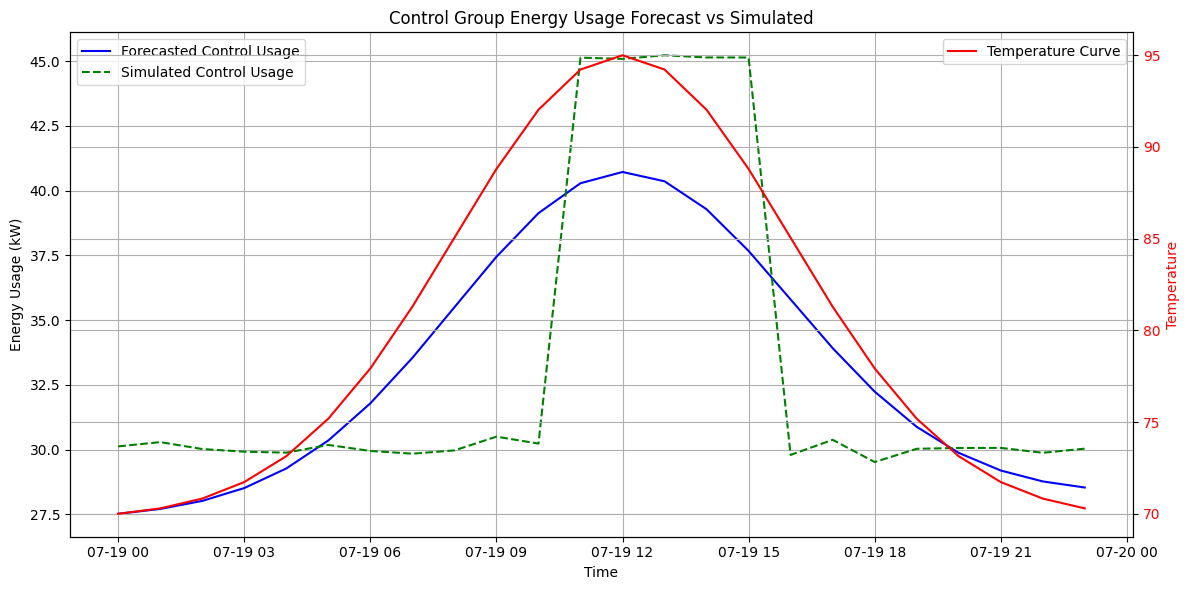

In [11]:
# Assuming 'forecast_control' and 'temperatures' are already defined correctly

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot forecasted data on the primary y-axis (left)
ax1.plot(forecast_control['ds'], forecast_control['yhat'], label='Forecasted Control Usage', color='blue')
ax1.plot(control_data['ds'], control_data['y'], label='Simulated Control Usage', color='green', linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Energy Usage (kW)')
ax1.tick_params(axis='y')
ax1.grid(True)

# Create a secondary y-axis (right) for temperature
ax2 = ax1.twinx()
ax2.plot(forecast_control['ds'], temperatures[:len(forecast_control)], label='Temperature Curve', linestyle='-', color='red')
ax2.set_ylabel('Temperature', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Control Group Energy Usage Forecast vs Simulated')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();